# Data Cleaning (Train)

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression

df = pd.read_csv('train.csv', index_col='Id')

initial_instance_count = len(df)
initital_feature_count = len(df.columns)

print(f'Anzahle von Exemplare: {initial_instance_count}\nAnzahle von Merkmale: {initital_feature_count}')



Anzahle von Exemplare: 2000
Anzahle von Merkmale: 80


In [10]:
# Deleting missing values, since there are only less than 1% of missing values
df = df.dropna(subset=['Wohngebiet', 'Funktionalitaet', 'KuechenQualitaet', 'Elektrik',
                       'Verkaufstyp', 'Garagenflaeche', 'Garagenautos'])

# Fill missing values with Linear Regression prediction in feature 'Strassenlaenge'
model = LinearRegression()
model.fit(np.array(df[df['Strassenlaenge'].notna()].Verkaufspreis).reshape(-1, 1), 
          df[df['Strassenlaenge'].notna()].Strassenlaenge)
predicted_values = model.predict(np.array(df[df['Strassenlaenge'].isna()].Verkaufspreis).reshape(-1, 1))
df.loc[df['Strassenlaenge'].isnull(), 'Strassenlaenge'] = predicted_values


# Fill missing values with mode
features_fillna_mode = ['Funktionalitaet', 'KuechenQualitaet', 'Elektrik', 'Garagenbaujahr',
                        'Garageninnenausbau', 'Garagentyp']
for feature in features_fillna_mode:
    df[feature] = df[feature].fillna(df[feature].mode()[0])


# Fill missing values with Nan
features_fillna_nan = ['Kellerhoehe', 'Kellerzustand', 'Kellerbelichtung', 
                     'Kellerbereich1', 'Kellerbereich2', 'Kaminqualitaet',
                     'Zaunqualitaet']
for feature in features_fillna_nan:
    df[feature] = df[feature].fillna('Nan')


# Fill missing values with 0.0
features_fillna_0 = ['Kellerbereichgroesse1', 'Kellerbereichgroesse2', 'KellerbereichgroesseGes', 
                     'KellerbereichgroesseNAu', 'KellerVollbadezimmer', 'KellerHalbbadezimmer',
                     'Mauerwerkflaeche']
for feature in features_fillna_0:
    df[feature] = df[feature].fillna(0.0)


# Fill Mauerwerktyp with 'Kein'
df['Mauerwerktyp'] = df['Mauerwerktyp'].fillna('Kein')


# Deleting features 'Versorgung' because there are 2 missing values and others are 'EGWA'
# Deleting features 'Kellerbereichgroesse2' because there are no good distribution of values 
# Delete other features because they have too many null values
df = df.drop(['Versorgung', 'Kellerbereichgroesse2', 'GeringequalitaetFlaeche',
              'Zufahrtsweg', 'Sondermerkmal', 'Poolqualitaet',
              'Garagenqualitaet', 'Garagenzustand'], axis=1)


In [11]:
# Limit 'Grundstuecksgroesse' with 6000 m2
df = df[df['Grundstuecksgroesse'] < 6000]

# Limit 'Strassenlaenge' with 60 m
df = df[df['Strassenlaenge'] <= 60]

# Delete instance 714 because there Baujahr is bigger than Umbaujahr
df = df[df['Umbaujahr'] >= df['Baujahr']]

# Delete Garagenbaujahr bigger than 2023
df = df[df['Garagenbaujahr'] < 2023]

In [12]:
# Delete 'Bedingung2' because there are only 13 values which are not 'Norm'
df = df.drop('Bedingung2', axis=1)

# Merge values EbOA, EbOU, EbNA, EbNU into 'Hbf' and PosN, PosA into 'Pos' for 'Bedingung1' feature
df['Bedingung1'] = df['Bedingung1'].replace(['EbOA', 'EbOU', 'EbNA', 'EbNU'], 'Hbf')
df['Bedingung1'] = df['Bedingung1'].replace(['PosN', 'PosA'], 'Pos')

# Delete features 'Grundstuecksform', 'Gelaendeneigun', 'Strassentyp', 'Dachmaterial' because of bad distribution of values
df = df.drop(['Grundstuecksform', 'Gelaendeneigung', 'Strassentyp', 'Dachmaterial'], axis=1)

In [13]:
final_instance_count = len(df)
final_feature_count = len(df.columns)

print(f'{initial_instance_count - final_instance_count} '
      f'({round((initial_instance_count - final_instance_count) / initial_instance_count * 100, 3)}%)'
      f' Exemplare wurden entfernt. \nAnzahle von Exemplare: {final_instance_count}'
      f'\nAnzahle von Merkmale: {final_feature_count}')


14 (0.7%) Exemplare wurden entfernt. 
Anzahle von Exemplare: 1986
Anzahle von Merkmale: 67


In [14]:
df.isna().sum().sort_values(ascending=False).head(5)

Wohngebiet                    0
GeschlosseneVerandaflaeche    0
Funktionalitaet               0
OberirdischeVollbadezimmer    0
OberirdischeHalbbadezimmer    0
dtype: int64

Count of different values in features Garagenbaujahr and Baujahr: 18 %


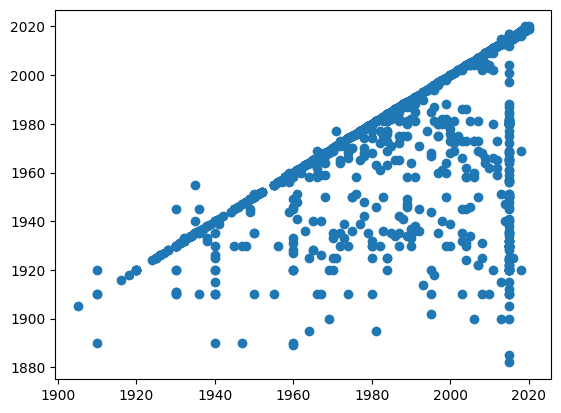

In [15]:
plt.scatter(df.Garagenbaujahr, df.Baujahr)
buf = df[(df.Garagenbaujahr != df.Baujahr) & (df.Garagenbaujahr != 2015)].shape[0] / df.shape[0] * 100
print('Count of different values in features Garagenbaujahr and Baujahr:', round(buf), '%')

# Data Cleaning (Test)

# Training

In [19]:
from sklearn.model_selection import train_test_split


df_encoded = pd.get_dummies(df)

X = df_encoded.drop('Verkaufspreis', axis=1)
y = df_encoded['Verkaufspreis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
# Create a random forest regressor
forest = RandomForestRegressor(random_state=42, n_estimators=800,min_samples_split=2,min_samples_leaf=1,max_features='sqrt',max_depth=40,bootstrap=False )

# Train the model
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

R^2 Score: 0.9181558489956247
Mean Squared Error: 293644783.56893957


# Evaluation